In [3]:
from flv_utils import get_h5_by_name, by_class
import flv_utils as flv
from flv_utils import Path
from matplotlib import pyplot as plt
import pandas as pd
import glob
import os
import h5py

In [4]:
h5 = get_h5_by_name("2022-07-27-31")
ava = by_class("AVA")

In [5]:

def load_labeled_traces_from_dataset(dataset, confidence_threshold=0.5):
    """Load labeled traces from a dataset.
    
    Args:
        dataset (str): The name of the dataset to load.
        confidence_threshold (float): The confidence threshold for including neuron classes.
    
    Returns:
        unnormalized_traces (np.ndarray): The unnormalized traces from the dataset.
        neuron_class_to_idx (dict): A mapping from neuron class names to their corresponding indices.
        idx_to_neuron_class (dict): A mapping from indices to their corresponding neuron class names.
    """
    dataset_path = flv.get_dataset_h5_path(dataset)

    h5_data = flv.get_h5_by_name(dataset_path)

    path_to_dataset = flv.get_dataset_h5_path(dataset)
    path_to_project = Path(path_to_dataset).parent.parent
    project_label_paths = glob.glob(str(path_to_project / "labels_csv/*"))
    dataset_label_path = [p for p in project_label_paths if dataset in p][0]

    structured_data_path = path_to_project / "structured_data.csv"

    if structured_data_path is not None and os.path.exists(structured_data_path):
        structured_df = pd.read_csv(structured_data_path)
        flipped = structured_df[structured_df["Dataset"] == dataset]["Flipped"].iloc[0]
    else:
        flipped = False

    print(f"This dataset is {'flipped' if flipped else 'not flipped'}")

    unnormalized_traces = h5_data["gcamp"]["trace_array_original"].T

    neuron_class_to_idx = {}
    idx_to_neuron_class = {}

    if dataset_label_path is not None:
        try:
            if dataset_label_path.endswith(".xlsx"):
                # Read the Excel file into a DataFrame
                with open(dataset_label_path, "rb") as f:
                    df = flv.load_excel_file(f)
            else:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(dataset_label_path)
        except Exception as e:
            raise ValueError(f"Error reading labels file: {e}")

        neuron_classes = list(df["Neuron Class"])
        roi_ids = list(df["ROI ID"])
        confidences = list(df["Confidence"])
        for neuron_class, roi_id, confidence in zip(
            neuron_classes, roi_ids, confidences
        ):
            roi_id = int(float(str(roi_id).split("/")[0]))
            if confidence < confidence_threshold:
                continue
            neuron_class_to_idx[neuron_class] = int(
                h5_data["neuropal_registration"]["roi_match"][roi_id - 1] - 1
            )

        idx_to_neuron_class = {v: k for k, v in neuron_class_to_idx.items() if v != -1}

    for i in range(unnormalized_traces.shape[0]):
        idx_to_neuron_class[i] = idx_to_neuron_class.get(i, f"Neuron_{i:03d}")


    return unnormalized_traces, neuron_class_to_idx, idx_to_neuron_class

dataset = '2022-07-27-31'
unnormalized_traces, neuron_class_to_idx, idx_to_neuron_class = load_labeled_traces_from_dataset(dataset, confidence_threshold=0.5)

This dataset is flipped


In [6]:
neuron_class_to_idx['I1L']

4

In [7]:
[x for x,y in neuron_class_to_idx.items() if y == 0]

['AVEL']

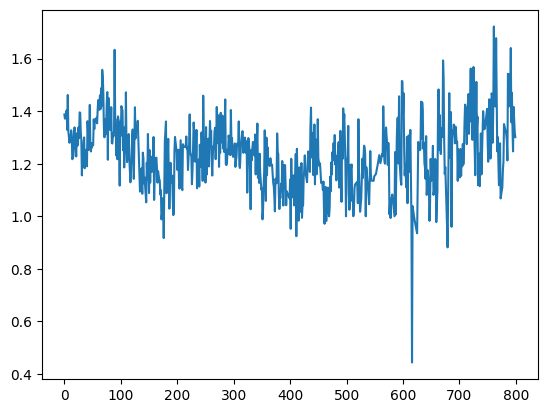

In [8]:
plt.plot(unnormalized_traces[neuron_class_to_idx['AVHL']])

In [9]:
%matplotlib inline

Skipping IL2R


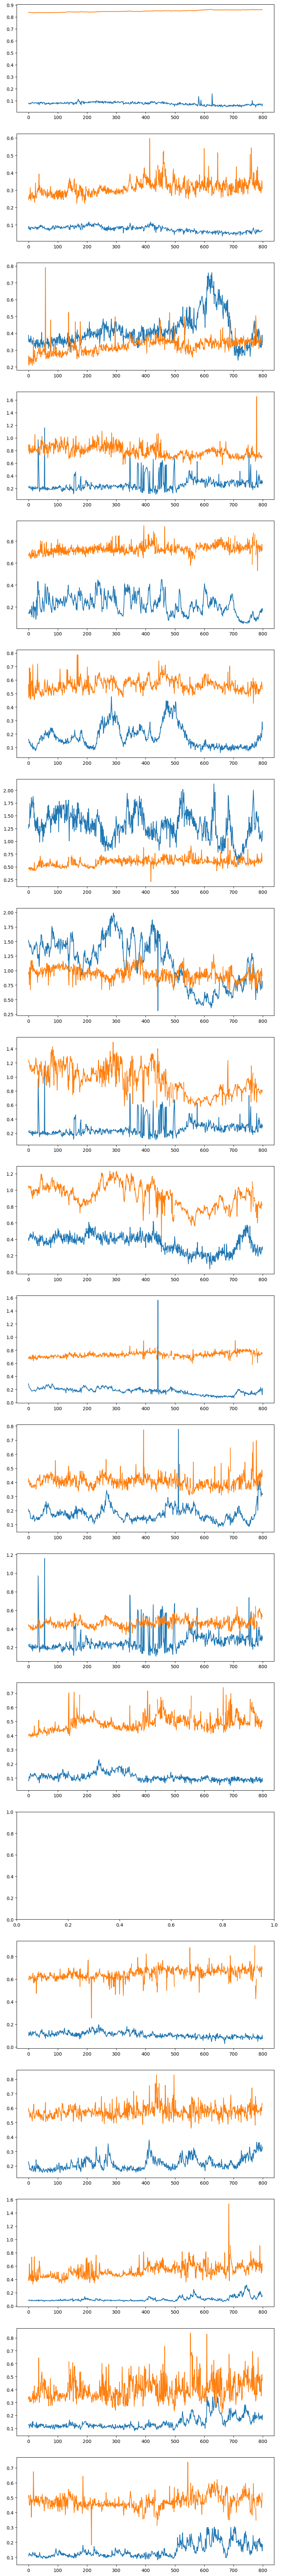

In [10]:
with h5py.File("/data3/adam/new_unet_train/extracted_neuron_ids_final_1.h5", "r") as f:
    neuron_ids = [name.decode('utf-8') for name in f['neuron_ids'][:]]

while True:
    try:
        with h5py.File("/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/NRRD_raw/liveTraces.h5", "r") as f:
            live_traces = f["signal"][:]
            break
    except:
        pass
neuron_ids = neuron_ids[:20]

axes = plt.subplots(len(neuron_ids), 1, figsize=(10, 5 * len(neuron_ids)))[1]
for i, neuron in enumerate(neuron_ids):
    # print(neuron)
    if neuron not in neuron_class_to_idx:
        print(f"Skipping {neuron}")
        continue
    axes[i].plot(unnormalized_traces[neuron_class_to_idx[neuron]])
    axes[i].plot(live_traces[i])

plt.show()